# Import libraries

In [8]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns


# from sklearn.base import BaseEstimator, TransformerMixin
# 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, RANSACRegressor

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor



import optuna


import tqdm
import joblib
import pickle
# serializd your object and svaes its binary form 

import shap


pd.set_option('display.max_columns', 70)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False

style.use('ggplot')
sns.set_palette('Set2')
# blue, orange, green

import warnings
warnings.filterwarnings('ignore')

# Import data

In [9]:
train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('x_test.csv')

In [10]:
df_train = train.copy()
df_test = test.copy()

In [11]:
print(df_train.shape)
print(df_test.shape)

(75757, 64)
(9705, 63)


In [12]:
train.sample(5)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
11187,5,State_4,Commercial,Education_College_or_university,175129.0,1960.0,NaN,221.0,-8,21.935484,46,-13,15.696429,44,0,34.161290,72,27,48.200000,78,35,60.241935,86,41,65.366667,91,51,70.677419,94,50,71.564516,94,46,68.866667,93,29,54.064516,78,12,44.733333,73,15,39.693548,62,769,6226,41.75,44.8,426,49.800000,96,53,31,15,64,8,0,0,NaN,NaN,NaN,NaN,98.791192,11187
7364,4,State_2,Commercial,Lodging_Hotel,217504.0,1928.0,16.0,3.0,3,28.290323,59,13,34.107143,68,7,37.951613,70,31,54.450000,84,44,65.034483,90,54,74.483333,95,55,76.033333,97,55,73.550000,89,46,69.172414,93,38,59.183333,81,19,43.357143,72,23,40.350000,72,1170,4760,53.09,31.6,39,54.651685,88,26,12,0,93,17,0,0,NaN,NaN,NaN,NaN,126.522482,7364
1077,3,State_1,Commercial,Education_Uncategorized,21000.0,NaN,NaN,19.2,35,57.435484,86,39,58.482143,86,46,64.548387,92,51,67.033333,91,58,71.967742,104,63,73.966667,94,63,76.580645,97,62,77.387097,101,54,76.750000,103,49,67.564516,95,46,64.183333,94,36,58.387097,85,1902,748,3.84,0.0,0,67.905479,0,0,0,0,153,41,5,0,270.0,270.0,12.5,90.0,81.079997,1077
39825,4,State_6,Residential,Multifamily_Uncategorized,112100.0,1973.0,1.0,42.7,4,28.596774,58,9,31.625000,56,13,37.661290,66,31,52.333333,77,49,64.000000,86,55,72.450000,89,63,76.145161,91,61,74.516129,90,52,69.733333,92,42,59.629032,77,22,45.300000,69,24,40.516129,65,1128,4875,53.79,50.0,377,54.501370,66,24,7,0,75,4,0,0,1.0,1.0,1.0,NaN,616.046644,39825
49552,5,State_6,Residential,Multifamily_Uncategorized,741264.0,1974.0,NaN,42.7,8,29.854839,56,2,23.946429,43,12,38.096774,62,32,54.250000,80,48,68.516129,88,50,71.183333,90,64,78.790323,96,63,78.967742,95,56,74.450000,97,35,58.048387,78,32,52.783333,74,34,50.774194,72,1581,4460,40.97,49.1,463,56.835616,63,34,9,0,106,12,0,0,310.0,310.0,13.0,110.0,64.291595,49552


In [13]:
df_train.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

df_test.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

# EDA

In [14]:
numerical_feature = [feature for feature in df_train.columns if df_train[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df_train[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df_train.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 61
Discrete feature Count 6
Continuous feature Count 55
Categorical feature Count 3


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year_factor                75757 non-null  int64  
 1   state_factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   elevation                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [16]:
def unistats(df):
    import pandas as pd
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'Numeric','Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    
    for col in df:
        if pd.api.types.is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(),
                                  df[col].dtype, pd.api.types.is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(),
                                  df[col].quantile(0.25), df[col].median(), df[col].quantile(0.75), 
                                  df[col].max(), df[col].std(), df[col].skew(), df[col].kurt()]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(),
                                  df[col].dtype, pd.api.types.is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', 
                                  '-', '-', '-',
                                  '-', '-', '-', '-']
            
    return output_df.sort_values(by = ['Numeric', 'Skew', 'Unique'], ascending = False)

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(unistats(df_train))

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
days_above_110F,75757,0,9,int64,True,0,0.002442,0,0.0,0.0,0.0,16,0.14214,84.615712,7977.639084
days_above_100F,75757,0,40,int64,True,0,0.279539,0,0.0,0.0,0.0,119,2.252323,23.496211,957.297144
elevation,75757,0,193,float64,True,42.7,39.506323,-6.4,11.9,25.0,42.7,1924.5,60.656596,7.102841,133.39029
floor_area,75757,0,20433,float64,True,60000.0,165983.865858,943.0,62379.0,91367.0,166000.0,6385382.0,246875.79094,6.60721,80.090228
days_below_0F,75757,0,19,int64,True,0,0.876764,0,0.0,0.0,0.0,31,2.894244,4.740918,24.93105
site_eui,75757,0,61080,float64,True,65.819672,82.584693,1.001169,54.528601,75.293716,97.277534,997.86612,58.255403,4.739972,43.385673
days_above_90F,75757,0,87,int64,True,17,14.058701,0,6.0,12.0,17.0,185,10.943996,3.133425,22.455777
days_below_10F,75757,0,30,int64,True,0,4.886532,0,0.0,2.0,7.0,59,7.071221,2.303784,6.303868
june_max_temp,75757,0,43,int64,True,90,91.40028,67,89.0,90.0,94.0,119,3.604068,1.668076,4.811864
direction_peak_wind_speed,33946,41811,8,float64,True,1.0,62.779974,1.0,1.0,1.0,1.0,360.0,130.308106,1.64352,0.722306


In [18]:
def missing_values_table(df):
        # Total missing values by column
        mis_val = df.isnull().sum()
        
        # Percentage of missing values by column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # build a table with the thw columns
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [19]:
print("Train set columns with null values: ")
print(list(df_train.columns[df_train.isnull().any()]))
print('===========================================')
# Missing values for training data
missing_values_train = missing_values_table(df_train)
missing_values_train[:20].style.background_gradient(cmap='Reds')

Train set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 64 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,45796,60.500000
direction_peak_wind_speed,41811,55.200000
direction_max_wind_speed,41082,54.200000
max_wind_speed,41082,54.200000
energy_star_rating,26709,35.300000
year_built,1837,2.400000


In [20]:
print("Test set columns with null values: ")
print(list(df_test.columns[df_test.isnull().any()]))
print('===========================================')
# Missing values for test data
missing_values_test = missing_values_table(df_test)
missing_values_test[:20].style.background_gradient(cmap='Reds')

Test set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 63 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,9117,93.900000
direction_max_wind_speed,8575,88.400000
direction_peak_wind_speed,8575,88.400000
max_wind_speed,8575,88.400000
energy_star_rating,2254,23.200000
year_built,92,0.900000


In [21]:
print("Number of duplicates: ", df_train.duplicated().sum())

Number of duplicates:  0


# Combine the dataset for vizualization

In [22]:
test['site_eui'] = np.nan #63
test['dataset'] = 'test'
train['dataset'] = 'train'


# train = commondf["dataset"]  == "train"

df_all = pd.concat([train, test], axis=0, ignore_index=True)

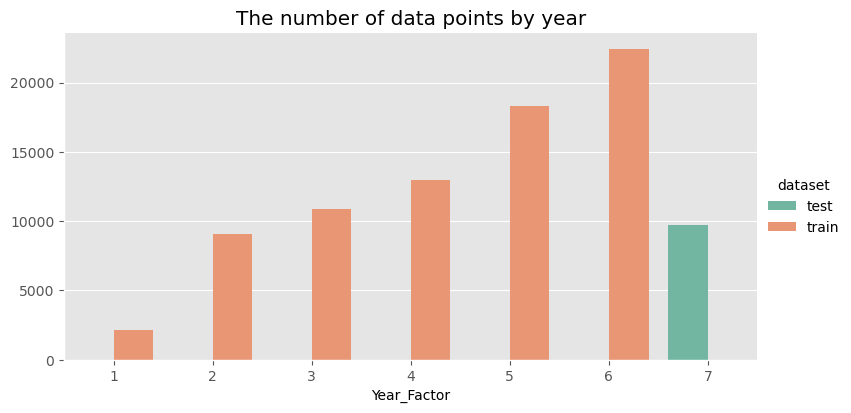

In [23]:
ax = sns.catplot(x='Year_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 kind='bar',
                 aspect=2,
                 height=4)\
.set(title="The number of data points by year",
     ylabel=None)

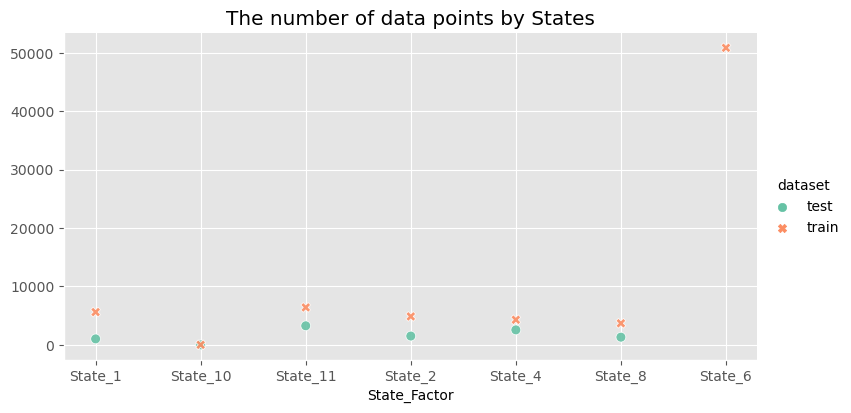

In [24]:
ax = sns.relplot(x='State_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=2,
                 height=4,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by States",
    ylabel=None)

Text(0.5, 0, '')

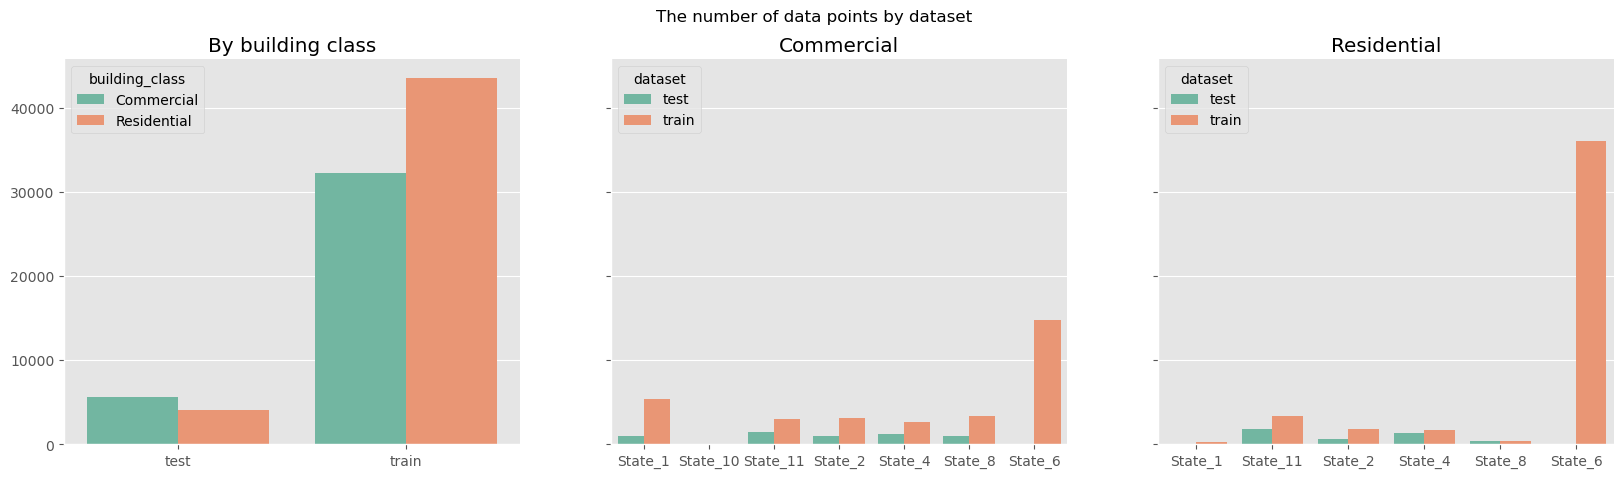

In [25]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='id',
            data=df_all.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)

for e, s in enumerate(df_all['building_class'].unique(),1):
    sns.barplot(x='State_Factor',
                y='id',
                data=df_all[df_all['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                ci=False)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")

ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

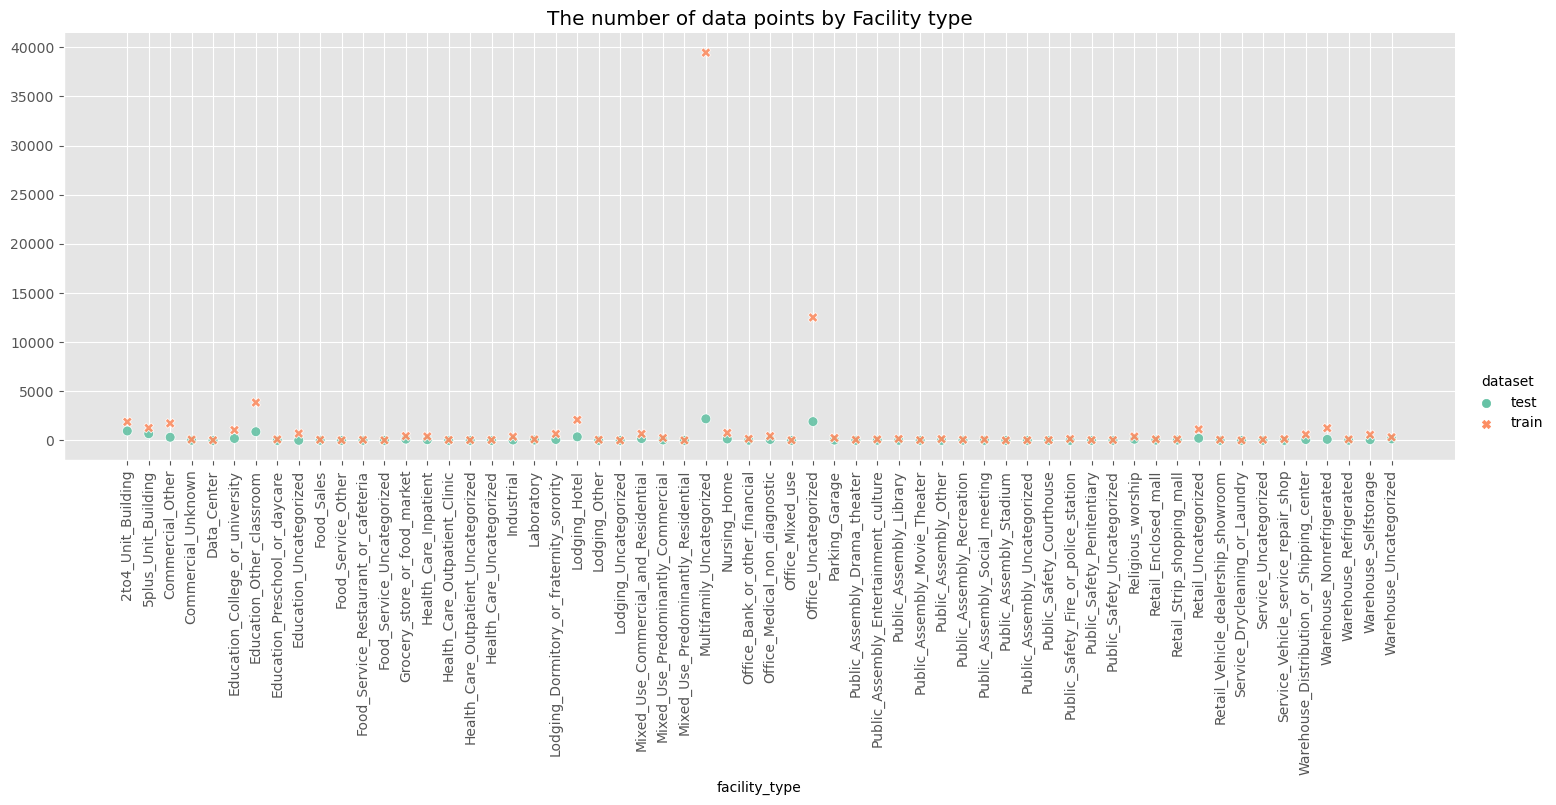

In [26]:
ax = sns.relplot(x='facility_type', 
                 y='id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by Facility type",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

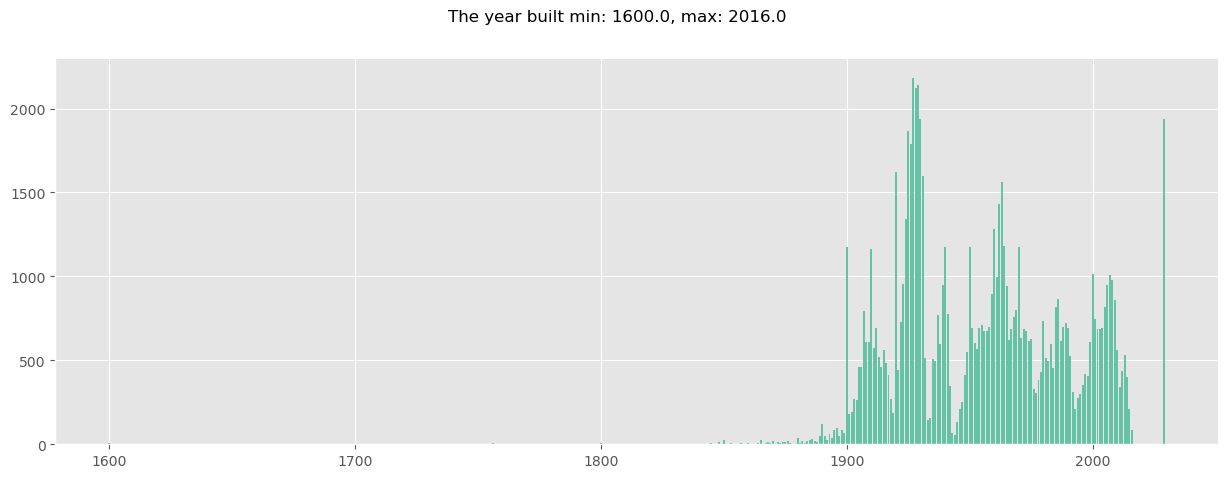

In [27]:
temp = df_all[['year_built']].fillna(2029).replace({0:2029}).astype('category').value_counts().reset_index().rename({0:'count'},axis=1)\
            .sort_values('year_built')
# temp['year_built'] = temp['year_built'].astype('category')
fig, ax = plt.subplots(figsize=(15,5))

ax=plt.bar(temp['year_built'],
           temp['count']
          )

fig.suptitle(f"The year built min: {min(temp['year_built'])}, max: {max(df_all['year_built'])}");

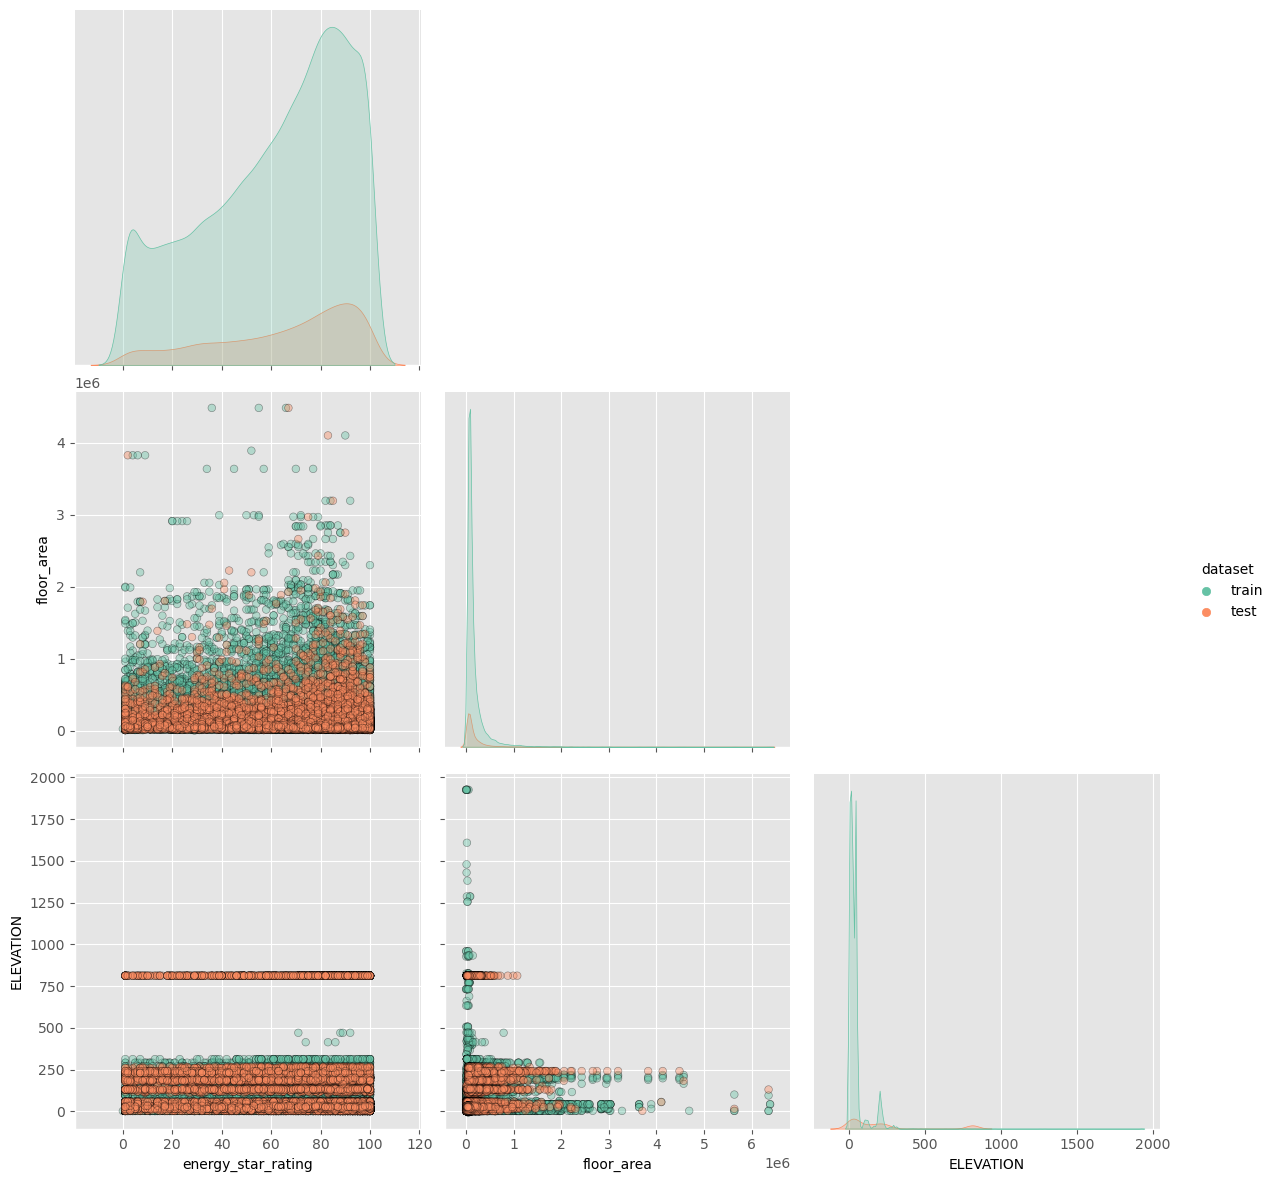

In [28]:
sns.pairplot(df_all,
            vars=['energy_star_rating','floor_area','ELEVATION'], 
            hue='dataset',
            height=4,
            plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k'},
            corner=True
           );

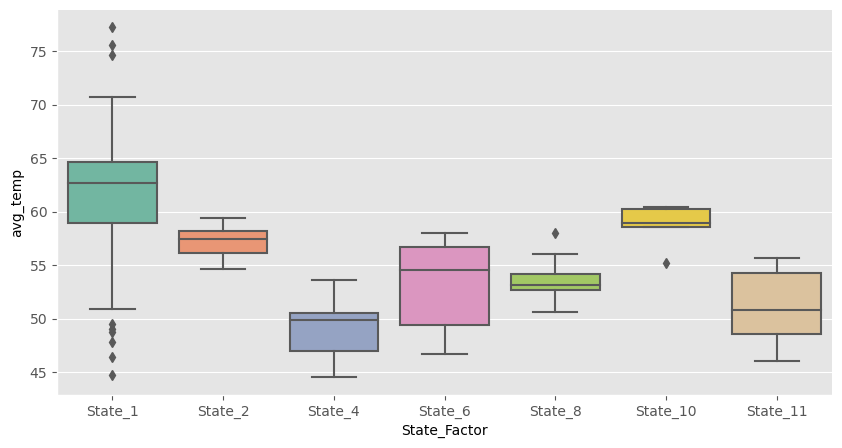

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','State_Factor']].drop_duplicates(), y='avg_temp', x='State_Factor');

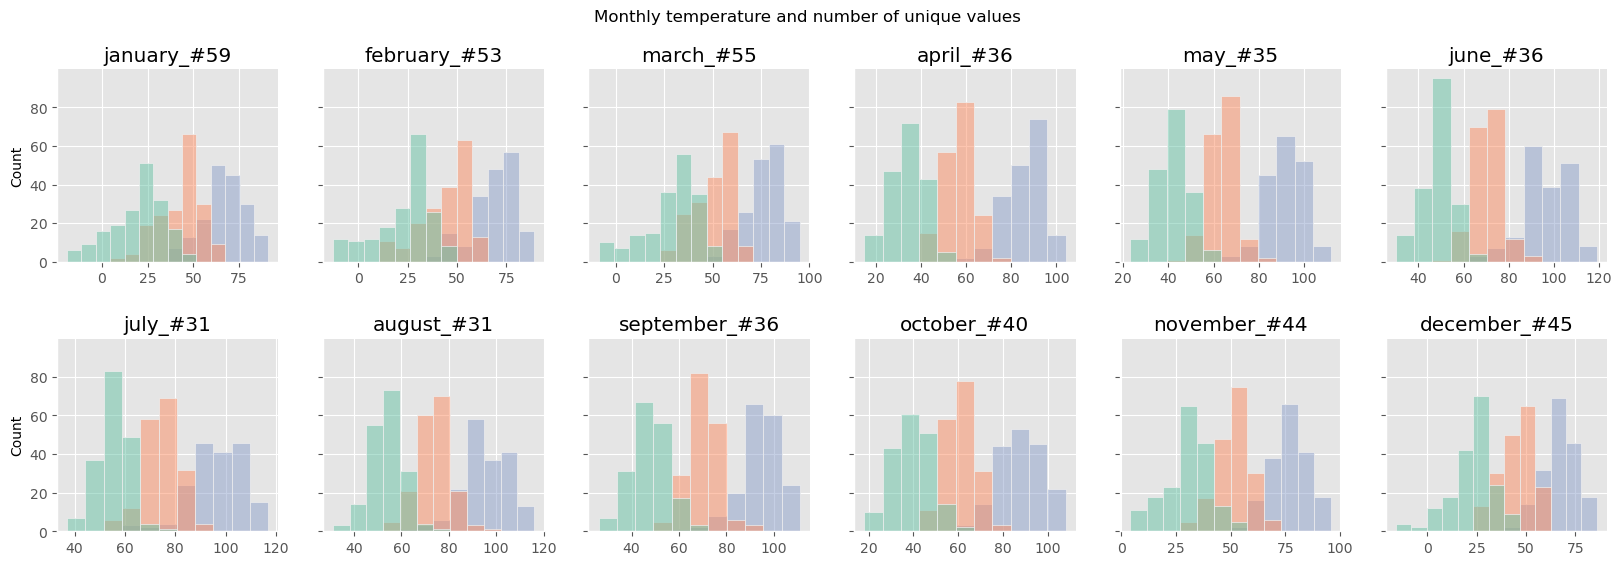

In [30]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]
        
fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

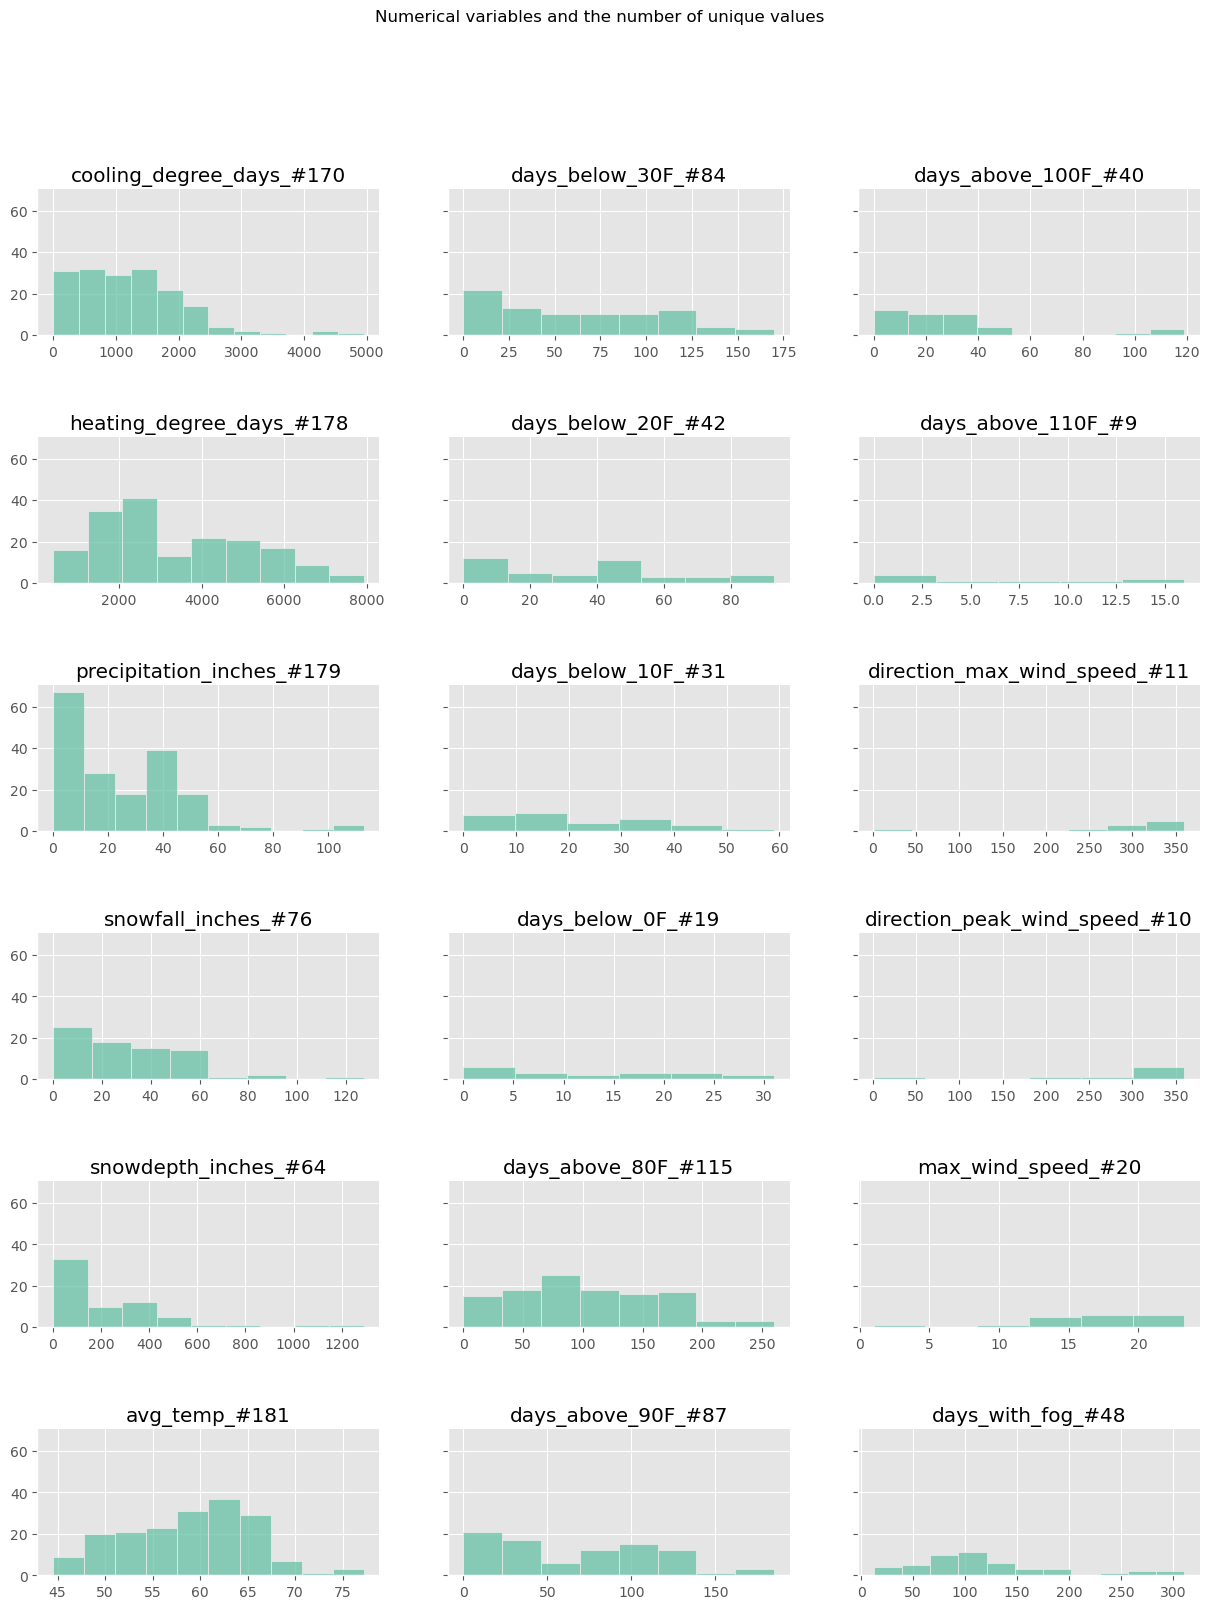

In [31]:
cols=['cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

fig, ax = plt.subplots(6,3, figsize=(15,18), sharey=True)
fig.suptitle("Numerical variables and the number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e,0], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    elif (e>=6) & (e<=11):
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-6,1], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-12,2], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
        
plt.subplots_adjust(hspace=0.7)

# Target variable exploration

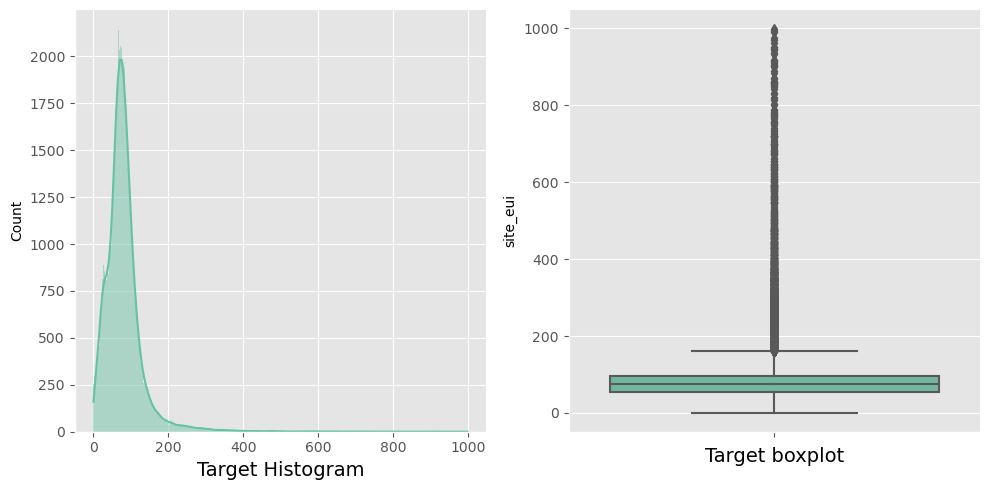

In [32]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=df_all['site_eui'], kde=True, palette='Set2')
ax1.set_xlabel('Target Histogram', fontsize=14)
ax2 = plt.subplot(1,2,2)
sns.boxplot(y=df_all['site_eui'], palette='Set2')
ax2.set_xlabel('Target boxplot', fontsize=14)
plt.tight_layout();

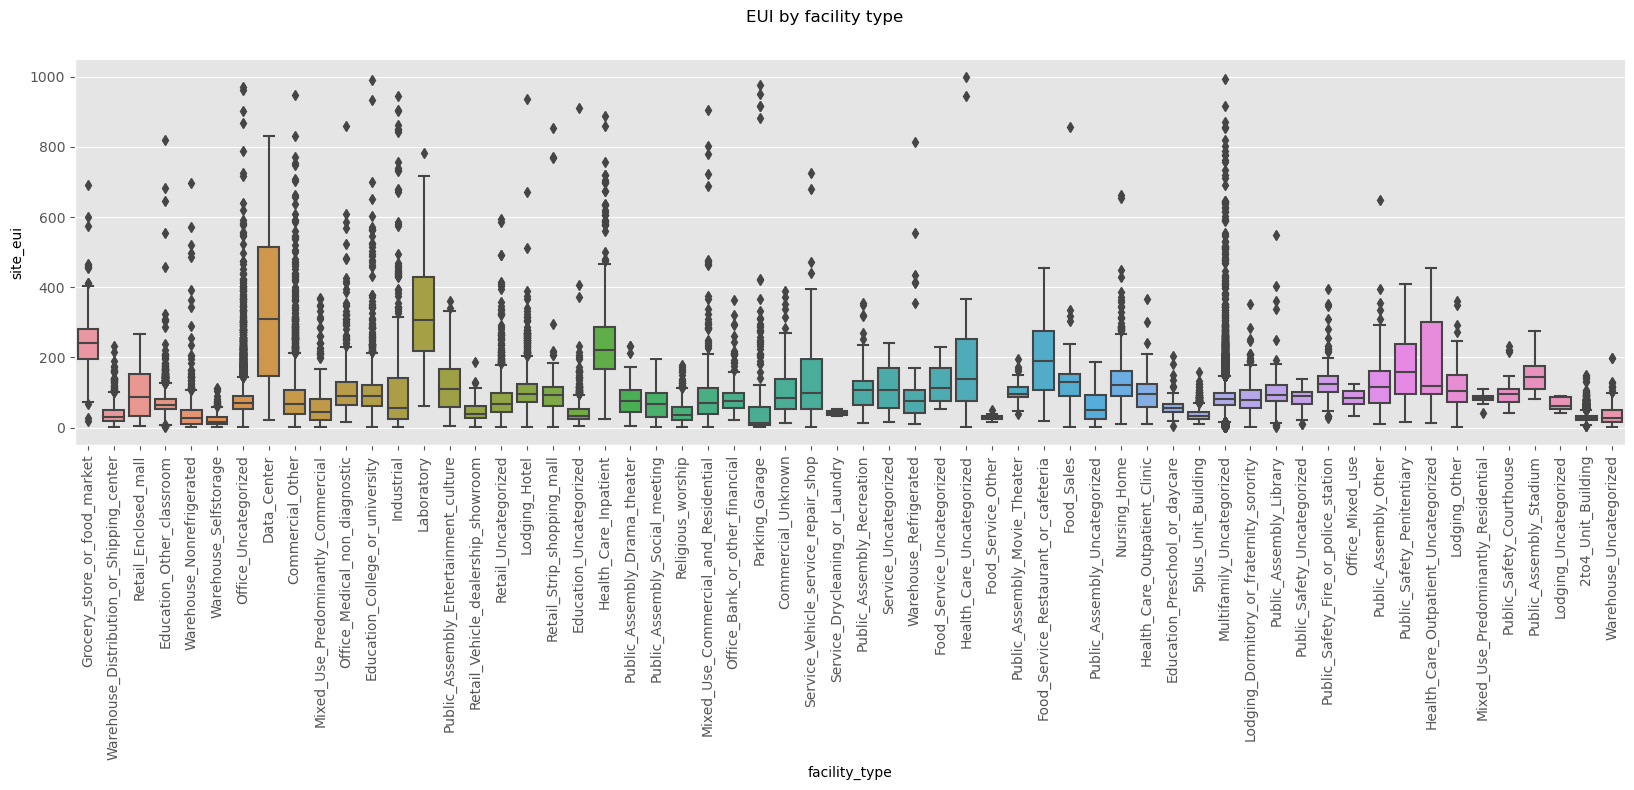

In [33]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [34]:
# Observation - labs and data centers tend to have more eui than other buildings

In [35]:
df_all

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0,train
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1,train
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2,train
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3,train
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7,State_11,Residential,5plus_Unit_Building,305925.0,2013.0,99.0,812.0,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,NaN,85457,test
85458,7,State_11,Residential,5plus_Unit_Building,34909.0,1910.0,94.0,26.5,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,NaN,85458,test
85459,7,State_11,Residential,5plus_Unit_Building,42393.0,2014.0,94.0,812.0,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83

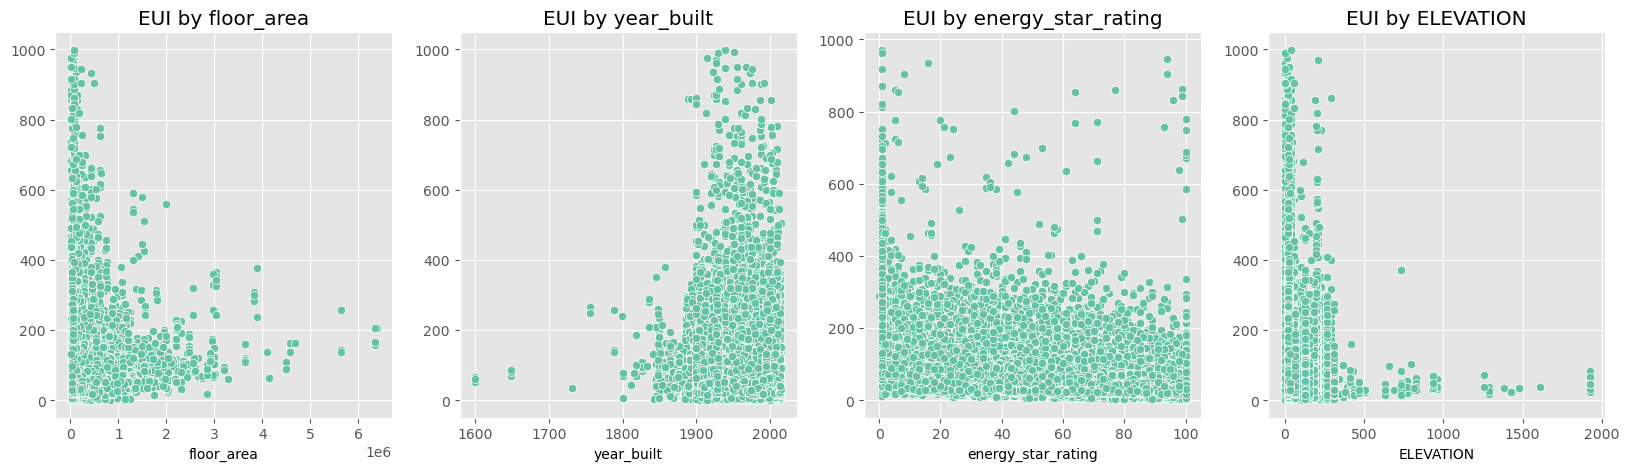

In [36]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for e, col in enumerate(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION']):
    if col =='year_built':
        sns.scatterplot(data=df_all[(df_all['year_built']!=0) & (df_all['year_built'].notna())], 
                        x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None)
    else:
        sns.scatterplot(data=df_all, x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None);

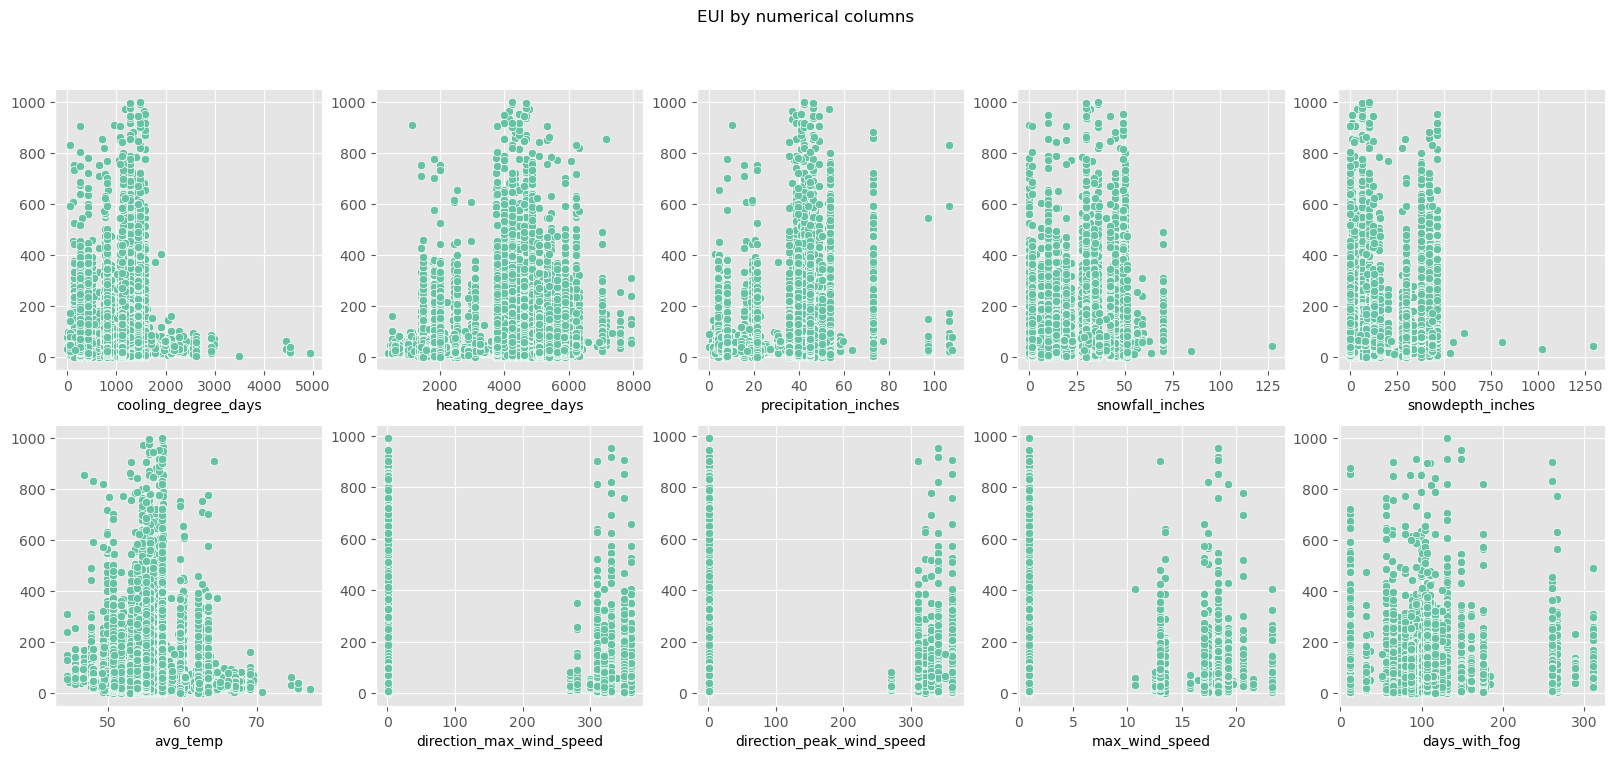

In [37]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches', 
      'snowfall_inches','snowdepth_inches'], 
      ['avg_temp', 
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 
      'days_with_fog']]

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')

for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=df_all, 
                        x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None);

In [38]:
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
df_all = df_all.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)

In [39]:
df_all.loc[:,df_all.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

In [40]:
df_all_one_hot = df_all.copy()

cats = ['State_Factor', 'facility_type', 'building_class']
for col in cats:
    dummies = pd.get_dummies(df_all_one_hot[col], dummy_na=False)
    for ohe_col in dummies:
        df_all_one_hot[f'ohe_{col}_{ohe_col}'] = dummies[ohe_col]

In [41]:
df_all_one_hot

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,ohe_facility_type_Multifamily_Uncategorized,ohe_facility_type_Nursing_Home,ohe_facility_type_Office_Bank_or_other_financial,ohe_facility_type_Office_Medical_non_diagnostic,ohe_facility_type_Office_Mixed_use,ohe_facility_type_Office_Uncategorized,ohe_facility_type_Parking_Garage,ohe_facility_type_Public_Assembly_Drama_theater,ohe_facility_type_Public_Assembly_Entertainment_culture,ohe_facility_type_Public_Assembly_Library,ohe_facility_type_Public_Assembly_Movie_Theater,ohe_facility_type_Public_Assembly_Other,ohe_facility_type_Public_Assembly_Recreation,ohe_facility_type_Public_Assembly_Social_meeting,ohe_facility_type_Public_Assembly_Stadium,ohe_facility_type_Public_Assembly_Uncategorized,ohe_facility_type_Public_Safety_Courthouse,ohe_facility_type_Public_Safety_Fire_or_police_station,ohe_facility_type_Public_Safety_Penitentiary,ohe_facility_type_Public_Safety_Uncategorized,ohe_facility_type_Religious_worship,ohe_facility_type_Retail_Enclosed_mall,ohe_facility_type_Retail_Strip_shopping_mall,ohe_facility_type_Retail_Uncategorized,ohe_facility_type_Retail_Vehicle_dealership_showroom,ohe_facility_type_Service_Drycleaning_or_Laundry,ohe_facility_type_Service_Uncategorized,ohe_facility_type_Service_Vehicle_service_repair_shop,ohe_facility_type_Warehouse_Distribution_or_Shipping_center,ohe_facility_type_Warehouse_Nonrefrigerated,ohe_facility_type_Warehouse_Refrigerated,ohe_facility_type_Warehouse_Selfstorage,ohe_facility_type_Warehouse_Uncategorized,ohe_building_class_Commercial,ohe_building_class_Residential
0,3,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,45.7,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90,45,65.129032,91,52,70.016667,104,52,71.387097,102,54,71.322581,97,47,69.133333,98,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,7,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,3,State_1,Commercial,Commercial_Other,10755.0,1937.0,NaN,9.1,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7,State_8,Residential,Multifamily_Uncategorized,900000.0,1960.0,90.0,130.8,2,33.435484,61,16,37.660714,73,8,35.935484,69,28,54.800000,85,38,59.096774,92,40,68.689655,91,53,74.677419,91,52,70.564516,89,40,66.250000,91,...,1,0,0,

In [42]:
df_all

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset
0,3,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,45.7,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90,45,65.129032,91,52,70.016667,104,52,71.387097,102,54,71.322581,97,47,69.133333,98,43,61.000000,84,36,55.116667,77,24,45.387097,68,826,2542,4.50,0.0,0,60.056164,20,0,0,0,111,31,5,0,NaN,NaN,NaN,NaN,6.800000,1456,train
1,4,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,55,68.661290,95,46,59.650000,76,41,56.790323,68,497,1477,20.69,0.0,0,62.067123,0,0,0,0,27,6,0,0,NaN,NaN,NaN,NaN,8.200000,2673,train
2,5,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,49,69.580645,96,29,52.866667,75,28,48.580645,68,1319,1823,7.95,0.0,0,63.398630,4,0,0,0,136,52,10,0,NaN,NaN,NaN,NaN,12.300000,3769,train
3,7,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,NaN,76077,test
4,3,State_1,Commercial,Commercial_Other,10755.0,1937.0,NaN,9.1,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,35,56.967742,85,31,52.516667,76,16,43.338710,68,303,3108,4.16,0.0,0,57.082192,33,2,0,0,72,10,0,0,NaN,NaN,NaN,NaN,63.083288,2144,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7,State_8,Residential,Multifamily_Uncategorized,900000.0,1960.0,90.0,130.8,2,33.435484,61,16,37.660714,73,8,35.935484,69,28,54.800000,85,38,59.096774,92,40,68.689655,91,53,74.677419,91,52,70.564516,89,40,66.250000,91,33,58.129032,83,17,41.583333,74,3,29.933333,57,866,5264,43.54,27.3,51,52.646006,97,45,13,0,77,5,0,0,NaN,NaN,NaN,NaN,NaN,79514,test
85458,6,State_8,Residential,Multifamily_Uncategorized,1179072.0,1959.0,96.0,3.0,8,29.827586,62,4,33.896552,62,24,45.967742,79,18,49.931034,81,37,59.161290,89,45,70.465517,90,57,77.083333,96,54,75.725806,95,40,68.200000,96,24,55.258065,85,20,44.316667,71,12,35.129032,58,1114,5074,35.78,13.9,18,53.839335,97,29,6,0,101,21,0,0,1.0,1.0,1.0,116.0,43.533097,68730,train
85459,7,State_8,Residential,Multifamily_Uncategorized,1179072.0,1959.0,92.0,130.8,2,33.435484,61,16,37.660714,73,8,35.935484,69,28,54.800000,85,38,59.096774,92,40,68.689655,91,53,74.677419,91,52,70.564516,89,40,66.250000,91,33,58.129032,83,17,41.583333,74,3,29.933333,57,866,5264,43.54,27.3,51,5

In [43]:
# This takes 1 hr, hence, unpickle the df1 and carry on with knn_imputing = False

knn_imputing = False
target='site_eui'

if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df = df_all.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    tmp.to_csv('imputer_tmp.csv', index=False)
    df1.to_csv('imputer_df1.csv', index=False)
    joblib.dump(imputer, 'knn_imputer.pkl')

else:
    df1 = pd.read_csv('imputer_df1.csv')
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df_all = df_all.drop(tmp.columns, axis=1)
    for col in tmp.columns:
        df_all[col]=tmp[col]
    for col in df1.columns:
        df_all[col] = df1[col]

In [44]:
df_all_te = df_all.copy()

cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all_te[col] = encoder.fit_transform(df_all_te[col], df_all_te[target])

In [45]:
# extract new weather statistics from the building location weather features
temp = [col for col in df_all_te.columns if 'temp' in col]

df_all_te['min_temp'] = df_all_te[temp].min(axis=1)
df_all_te['max_temp'] = df_all_te[temp].max(axis=1)
df_all_te['avg_temp'] = df_all_te[temp].mean(axis=1)
df_all_te['std_temp'] = df_all_te[temp].std(axis=1)
df_all_te['skew_temp'] = df_all_te[temp].skew(axis=1)


# by seasons
temp = pd.Series([col for col in df_all_te.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
df_all_te['min_winter_temp'] = df_all_te[winter_temp].min(axis=1)
df_all_te['max_winter_temp'] = df_all_te[winter_temp].max(axis=1)
df_all_te['avg_winter_temp'] = df_all_te[winter_temp].mean(axis=1)
df_all_te['std_winter_temp'] = df_all_te[winter_temp].std(axis=1)
df_all_te['skew_winter_temp'] = df_all_te[winter_temp].skew(axis=1)
### spring
df_all_te['min_spring_temp'] = df_all_te[spring_temp].min(axis=1)
df_all_te['max_spring_temp'] = df_all_te[spring_temp].max(axis=1)
df_all_te['avg_spring_temp'] = df_all_te[spring_temp].mean(axis=1)
df_all_te['std_spring_temp'] = df_all_te[spring_temp].std(axis=1)
df_all_te['skew_spring_temp'] = df_all_te[spring_temp].skew(axis=1)
### summer
df_all_te['min_summer_temp'] = df_all_te[summer_temp].min(axis=1)
df_all_te['max_summer_temp'] = df_all_te[summer_temp].max(axis=1)
df_all_te['avg_summer_temp'] = df_all_te[summer_temp].mean(axis=1)
df_all_te['std_summer_temp'] = df_all_te[summer_temp].max(axis=1)
df_all_te['skew_summer_temp'] = df_all_te[summer_temp].max(axis=1)
## autumn
df_all_te['min_autumn_temp'] = df_all_te[autumn_temp].min(axis=1)
df_all_te['max_autumn_temp'] = df_all_te[autumn_temp].max(axis=1)
df_all_te['avg_autumn_temp'] = df_all_te[autumn_temp].mean(axis=1)
df_all_te['std_autumn_temp'] = df_all_te[autumn_temp].std(axis=1)
df_all_te['skew_autumn_temp'] = df_all_te[autumn_temp].skew(axis=1)

In [46]:
df_all_te['month_cooling_degree_days'] = df_all_te['cooling_degree_days']/12
df_all_te['month_heating_degree_days'] = df_all_te['heating_degree_days']/12

In [47]:
df_all_te[temp]

,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,avg_temp,min_temp,max_temp,std_temp,skew_temp
0,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,43.0,61.000000,84.0,36.0,55.116667,77.0,24.0,45.387097,68.0,61.816451,24.0,104.0,21.308416,0.281828
1,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,55.0,68.661290,95.0,46.0,59.650000,76.0,41.0,56.790323,68.0,64.197549,41.0,95.0,14.980311,0.428700
2,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,49.0,69.580645,96.0,29.0,52.866667,75.0,28.0,48.580645,68.0,65.453067,28.0,106.0,21.906277,0.212369
3,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.450000,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,43.0,58.050000,69.0,38.0,51.887097,66.0,62.281685,38.0,104.0,16.708230,0.725826
4,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,35.0,56.967742,85.0,31.0,52.516667,76.0,16.0,43.338710,68.0,58.126280,16.0,99.0,22.272150,0.113857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,2.0,33.435484,61.0,16.0,37.660714,73.0,8.0,35.935484,69.0,28.0,54.800000,85.0,38.0,59.096774,92.0,40.0,68.689655,91.0,53.0,74.677419,91.0,52.0,70.564516,89.0,40.0,66.250000,91.0,33.0,58.129032,83.0,17.0,41.583333,74.0,3.0,29.933333,57.0,53.227074,2.0,92.0,26.069571,-0.249731
85458,8.0,29.827586,62.0,4.0,33.896552,62.0,24.0,45.967742,79.0,18.0,49.931034,81.0,37.0,59.161290,89.0,45.0,70.465517,90.0,57.0,77.083333,96.0,54.0,75.725806,95.0,40.0,68.200000,96.0,24.0,55.258065,85.0,20.0,44.316667,71.0,12.0,35.129032,58.0,54.210864,4.0,96.0,26.198215,-0.136906
85459,2.0,33.435484,61.0,16.0,37.660714,73.0,8.0,35.935484,69.0,28.0,54.800000,85.0,38.0,59.096774,92.0,40.0,68.689655,91.0,53.0,74.677419,91.0,52.0,70.564516,89.0,40.0,66.250000,91.0,33.0,58.129032,83.0,17.0,41.583333,74.0,3.0,29.933333,57.0,53.227074,2.0,92.0,26.069571,-0.249731
85460,8.0,29.827586,62.0,4.0,33.896552,62.0,24.0,45.967742,79.0,18.0,49.931034,81.0,37.0,59.161290,89.0,45.0,70.465517,90.0,57.0,77.083333,96.0,54.0,75.725806,95.0,40.0,68.200000,96.0,24.0,55.258065,85.0,20.0,44.316667,71.0,12.0,35.129032,58.0,54.210864,4.0,96.0,26.198215,-0.136906


In [48]:
# total area
df_all_te['building_area'] = df_all_te['floor_area'] * df_all_te['ELEVATION']
# rating energy by floor
df_all_te['floor_energy_star_rating'] = df_all_te['energy_star_rating']/df_all_te['ELEVATION']


In [49]:
df_all_te[["floor_area", "ELEVATION", "energy_star_rating", "floor_energy_star_rating", "building_area"]]

,floor_area,ELEVATION,energy_star_rating,floor_energy_star_rating,building_area
0,10149.0,45.7,38.428571,0.840888,463809.3
1,10149.0,120.4,43.571429,0.361889,1221939.6
2,10149.0,59.1,37.571429,0.635726,599805.9
3,10149.0,59.1,60.285714,1.020063,599805.9
4,10755.0,9.1,45.571429,5.007849,97870.5
...,...,...,...,...,...
85457,900000.0,130.8,90.000000,0.688073,117720000.0
85458,1179072.0,3.0,96.000000,32.000000,3537216.0
85459,1179072.0,130.8,92.000000,0.703364,154222617.6
85460,1195034.0,3.0,75.000000,25.000000,3585102.0


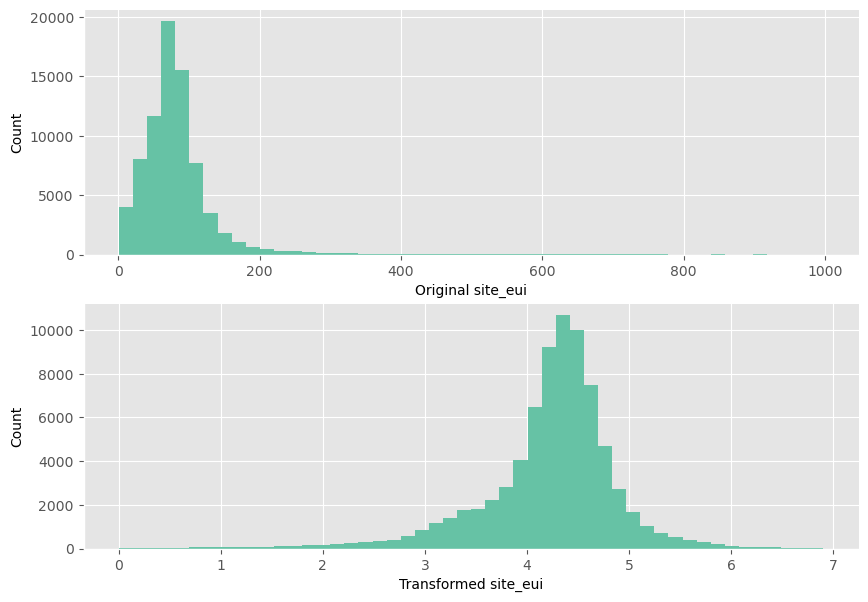

In [50]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

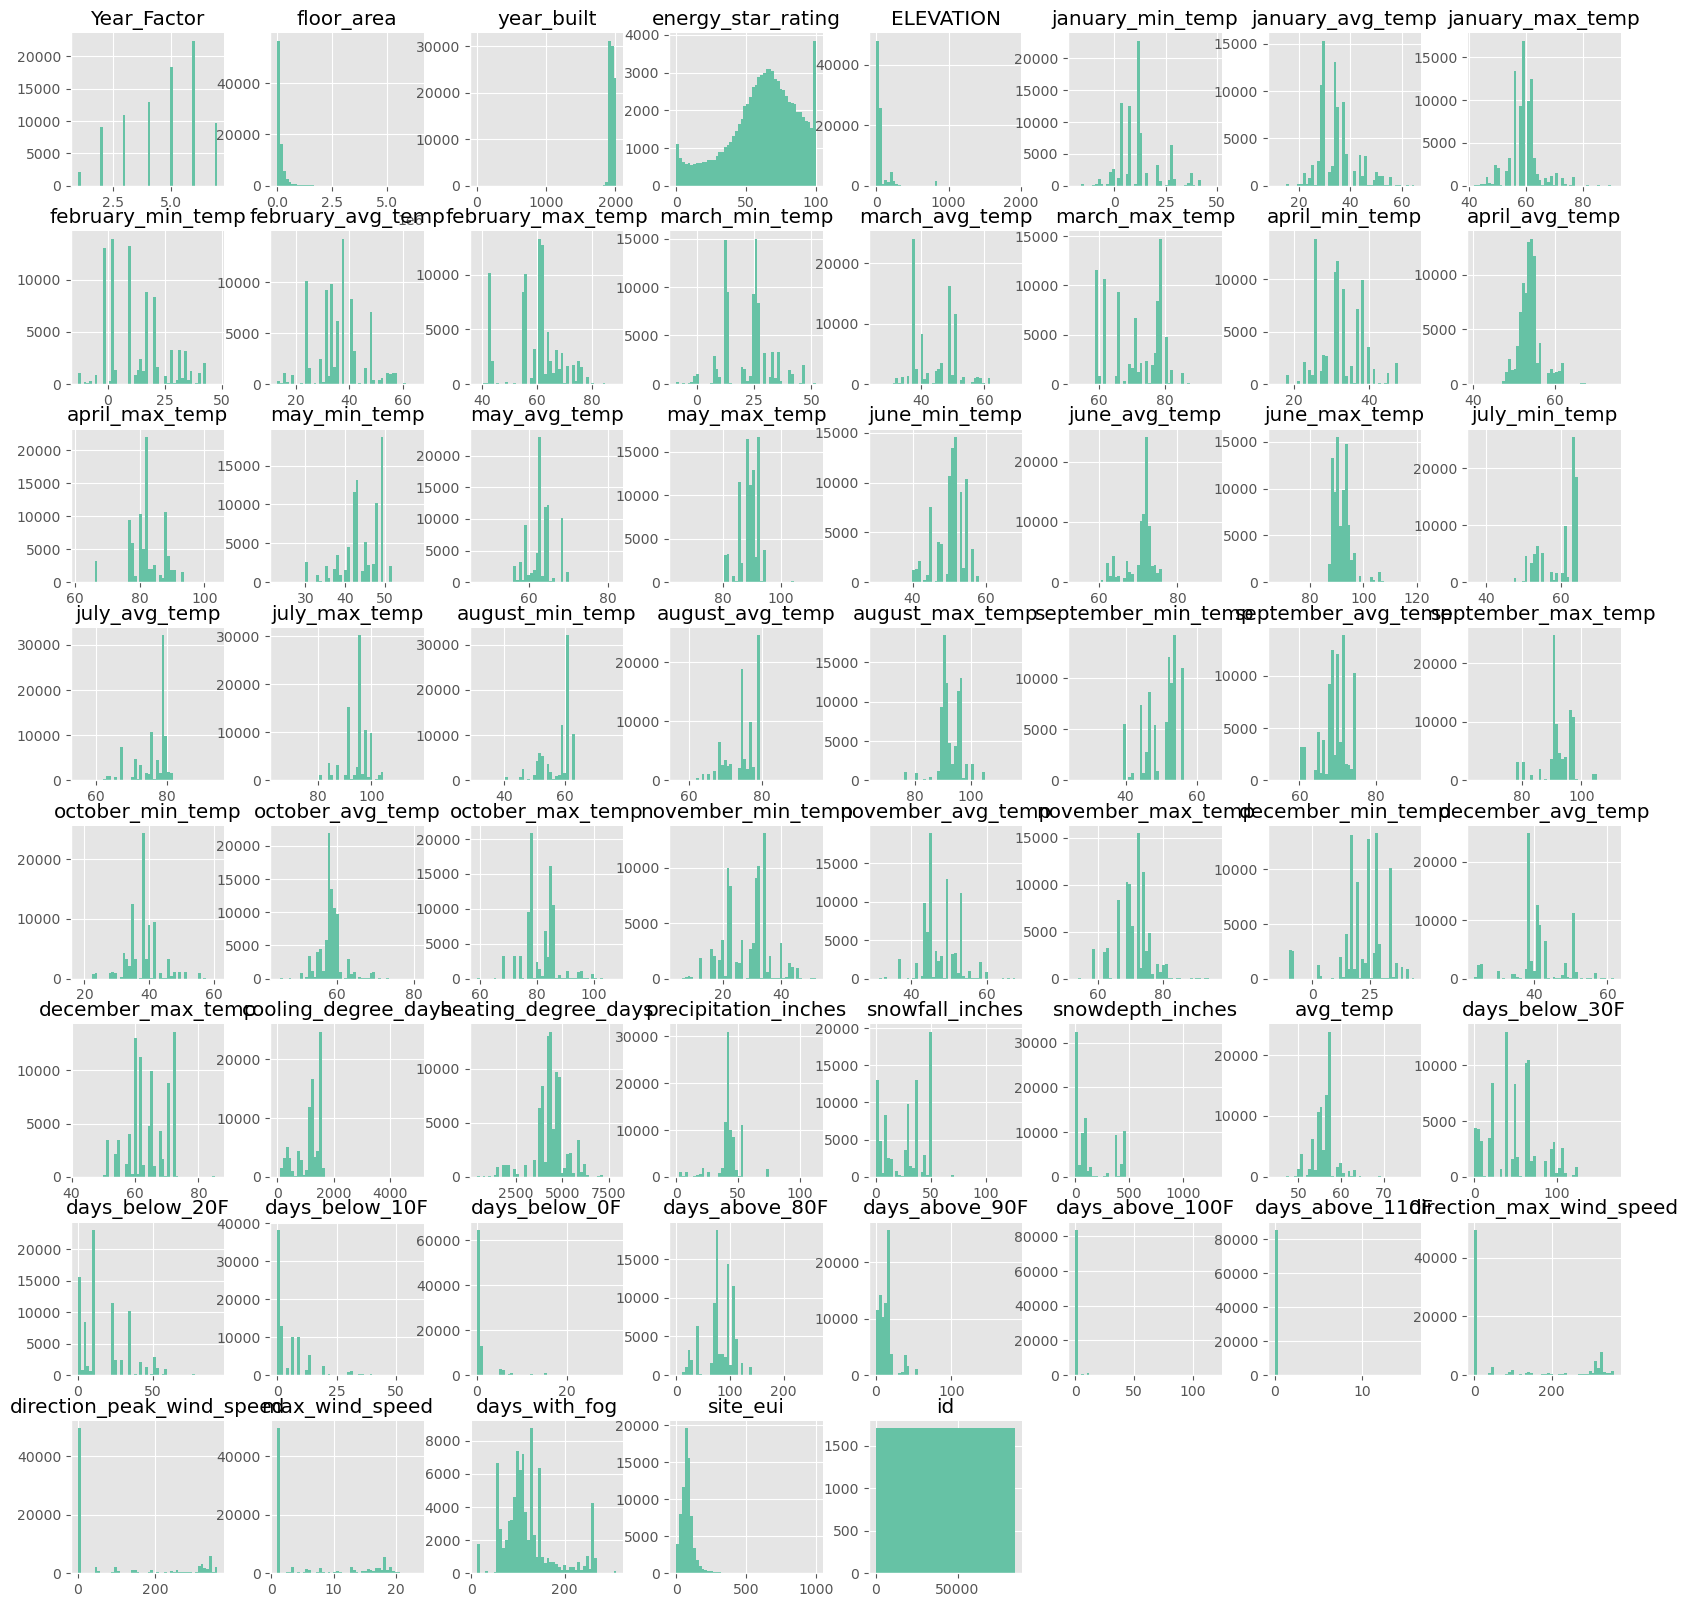

In [51]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].hist(bins=50, figsize=(20,20))
plt.show();

In [52]:
df_all_te[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F    89.873857
days_above_100F    24.615438
year_built        -11.716647
floor_area          6.701786
ELEVATION           5.140444
dtype: float64

In [53]:
# Binarize very skewed variables

In [54]:
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    
    # map the variable values into 0 and 1
    df_all_te[var] = np.where(df_all_te[var]==0, 0, 1)

In [55]:
saved = False
if saved:
    !pip install pickle5 --quiet
    import pickle5 as pickle
    data_path = 'feature_transformed_set_TEonly.pkl'
    with open(data_path, "rb") as fh:
        df = pickle.load(fh)
else:
    df_all.to_pickle('feature_transformed_set_TEonly.pkl')

In [56]:
df_all_te.shape

(85462, 93)

In [57]:
df_all_te.head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,...,days_with_fog,id,State_Factor,building_class,facility_type,dataset,site_eui,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,10149.0,1931.0,38.428571,45.7,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,43.0,61.000000,84.0,...,122.000000,1456.0,62.196194,85.755239,92.642037,train,6.800000,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,0.840888
1,4.0,10149.0,1931.0,43.571429,120.4,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,55.0,68.661290,95.0,...,122.000000,2673.0,62.196194,85.755239,92.642037,train,8.200000,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.361889
2,5.0,10149.0,1931.0,37.571429,59.1,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,49.0,69.580645,96.0,...,121.000000,3769.0,62.196194,85.755239,92.642037,train,12.300000,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,0.635726
3,7.0,10149.0,1931.0,60.285714,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.450000,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,...,138.285714,76077.0,62.196194,85.755239,92.642037,test,NaN,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.020063
4,3.0,10755.0,1937.0,45.571429,9.1,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,35.0,56.967742,85.0,...,112.714286,2144.0,62.196194,85.755239,92.642037,train,63.083288,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,5.007849


In [58]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_all_te.dtypes)

Year_Factor                  float64
floor_area                   float64
year_built                   float64
energy_star_rating           float64
ELEVATION                    float64
january_min_temp             float64
january_avg_temp             float64
january_max_temp             float64
february_min_temp            float64
february_avg_temp            float64
february_max_temp            float64
march_min_temp               float64
march_avg_temp               float64
march_max_temp               float64
april_min_temp               float64
april_avg_temp               float64
april_max_temp               float64
may_min_temp                 float64
may_avg_temp                 float64
may_max_temp                 float64
june_min_temp                float64
june_avg_temp                float64
june_max_temp                float64
july_min_temp                float64
july_avg_temp                float64
july_max_temp                float64
august_min_temp              float64
a

# Baseline Modelling

In [59]:
# cats = ['State_Factor', 'facility_type', 'building_class', 'days_above_100F', 'days_above_110F']

# typecasting numerical features
for col in df_all_te.drop(columns=['dataset', 'id', 'site_eui', 'days_above_100F', 'days_above_110F']).columns:
    df_all_te[col] = df_all_te[col].astype('float64')

In [60]:
df_all_te

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,...,days_with_fog,id,State_Factor,building_class,facility_type,dataset,site_eui,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,10149.0,1931.0,38.428571,45.7,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,43.0,61.000000,84.0,...,122.000000,1456.0,62.196194,85.755239,92.642037,train,6.800000,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,0.840888
1,4.0,10149.0,1931.0,43.571429,120.4,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,55.0,68.661290,95.0,...,122.000000,2673.0,62.196194,85.755239,92.642037,train,8.200000,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.361889
2,5.0,10149.0,1931.0,37.571429,59.1,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,49.0,69.580645,96.0,...,121.000000,3769.0,62.196194,85.755239,92.642037,train,12.300000,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,0.635726
3,7.0,10149.0,1931.0,60.285714,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.450000,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,...,138.285714,76077.0,62.196194,85.755239,92.642037,test,NaN,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.020063
4,3.0,10755.0,1937.0,45.571429,9.1,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,35.0,56.967742,85.0,...,112.714286,2144.0,62.196194,85.755239,92.642037,train,63.083288,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,5.007849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7.0,900000.0,1960.0,90.00000

In [61]:
train = df_all_te[df_all_te['dataset']=='train']
test = df_all_te[df_all_te['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui'] #y_train

train = train.drop(['id', 'dataset', 'site_eui'], axis=1) #X_train
test = test.drop(['id', 'dataset', 'site_eui'], axis=1) #X_test

In [62]:
y_test = pd.read_csv('y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 90)
Test: (9705, 90)
Samples:  (75757,)
Targets:  (9705,)


In [63]:
# get discrete end categorical features colums indexes 
# needed later for the cat bosst model
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]

In [64]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100
                        )

In [65]:
catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(X_test)

0:	learn: 57.8533053	test: 61.2069236	best: 61.2069236 (0)	total: 1.02s	remaining: 8m 31s
75:	learn: 44.8421708	test: 68.4312671	best: 61.2069236 (0)	total: 1m 4s	remaining: 5m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 61.20692361
bestIteration = 0

Shrink model to first 1 iterations.


In [66]:
# prepaere the out of folds predictions 
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits = NUM_FOLDS, shuffle=True, random_state=0)


for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = catb.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += catb.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))


0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 58.0511088	test: 57.0156693	best: 57.0156693 (0)	total: 676ms	remaining: 5m 37s
75:	learn: 45.1909786	test: 45.1320454	best: 45.1320454 (75)	total: 50.7s	remaining: 4m 42s
150:	learn: 42.1517055	test: 43.2749433	best: 43.2749433 (150)	total: 1m 41s	remaining: 3m 53s
225:	learn: 40.7622737	test: 42.7169726	best: 42.7169726 (225)	total: 2m 32s	remaining: 3m 4s
300:	learn: 39.8017591	test: 42.4112474	best: 42.4112474 (300)	total: 3m 24s	remaining: 2m 14s
375:	learn: 39.0574286	test: 42.2485290	best: 42.2485290 (375)	total: 4m 14s	remaining: 1m 24s
450:	learn: 38.4358353	test: 42.1204368	best: 42.1198925 (446)	total: 5m 5s	remaining: 33.2s
499:	learn: 38.0201315	test: 42.0346401	best: 42.0346401 (499)	total: 5m 38s	remaining: 0us

bestTest = 42.03464011
bestIteration = 499



1it [05:39, 339.91s/it]

out-of-folds prdiction ==== fold_0 RMSE 6.483412688467715


0:	learn: 57.9618277	test: 57.4326045	best: 57.4326045 (0)	total: 652ms	remaining: 5m 25s
75:	learn: 45.1148563	test: 45.5384904	best: 45.5384904 (75)	total: 52s	remaining: 4m 50s
150:	learn: 42.2090683	test: 43.5430803	best: 43.5430803 (150)	total: 1m 43s	remaining: 3m 59s
225:	learn: 40.9152765	test: 42.9043186	best: 42.9043186 (225)	total: 2m 35s	remaining: 3m 8s
300:	learn: 40.0261755	test: 42.5593927	best: 42.5593927 (300)	total: 3m 26s	remaining: 2m 16s
375:	learn: 39.2590726	test: 42.3442149	best: 42.3442149 (375)	total: 4m 16s	remaining: 1m 24s
450:	learn: 38.5984145	test: 42.1889315	best: 42.1889315 (450)	total: 5m 8s	remaining: 33.5s
499:	learn: 38.2152177	test: 42.1128830	best: 42.1128830 (499)	total: 5m 42s	remaining: 0us

bestTest = 42.11288298
bestIteration = 499



2it [11:23, 342.33s/it]

out-of-folds prdiction ==== fold_1 RMSE 6.489443963737514


0:	learn: 57.6684210	test: 58.5884399	best: 58.5884399 (0)	total: 685ms	remaining: 5m 41s
75:	learn: 44.3738321	test: 47.3328000	best: 47.3328000 (75)	total: 58.7s	remaining: 5m 27s
150:	learn: 41.4239528	test: 45.7816134	best: 45.7816134 (150)	total: 2m 3s	remaining: 4m 44s
225:	learn: 40.0125935	test: 45.3580863	best: 45.3580863 (225)	total: 3m 6s	remaining: 3m 46s
300:	learn: 39.0535346	test: 45.1471649	best: 45.1471649 (300)	total: 4m 6s	remaining: 2m 43s
375:	learn: 38.3271338	test: 45.0707531	best: 45.0700091 (374)	total: 5m 1s	remaining: 1m 39s
450:	learn: 37.7053584	test: 44.9965119	best: 44.9965119 (450)	total: 5m 54s	remaining: 38.5s
499:	learn: 37.2906885	test: 44.9467586	best: 44.9467586 (499)	total: 6m 31s	remaining: 0us

bestTest = 44.94675859
bestIteration = 499



3it [17:57, 365.50s/it]

out-of-folds prdiction ==== fold_2 RMSE 6.7042343846758055


0:	learn: 58.4738287	test: 55.3705797	best: 55.3705797 (0)	total: 948ms	remaining: 7m 52s
75:	learn: 45.2318324	test: 43.7375162	best: 43.7375162 (75)	total: 59.4s	remaining: 5m 31s
150:	learn: 42.1658177	test: 42.2083307	best: 42.2083307 (150)	total: 1m 53s	remaining: 4m 22s
225:	learn: 40.7526916	test: 41.8661172	best: 41.8661172 (225)	total: 2m 50s	remaining: 3m 26s
300:	learn: 39.8346487	test: 41.7344693	best: 41.7344693 (300)	total: 3m 42s	remaining: 2m 27s
375:	learn: 39.1065975	test: 41.6719369	best: 41.6719369 (375)	total: 4m 36s	remaining: 1m 31s
450:	learn: 38.5377653	test: 41.6391462	best: 41.6358942 (449)	total: 5m 29s	remaining: 35.8s
499:	learn: 38.1100580	test: 41.5843776	best: 41.5838284 (496)	total: 6m 1s	remaining: 0us

bestTest = 41.5838284
bestIteration = 496

Shrink model to first 497 iterations.


4it [23:59, 364.41s/it]

out-of-folds prdiction ==== fold_3 RMSE 6.448552427527569


0:	learn: 57.0899815	test: 60.8246576	best: 60.8246576 (0)	total: 671ms	remaining: 5m 34s
75:	learn: 44.3052922	test: 48.6257520	best: 48.6257520 (75)	total: 53.1s	remaining: 4m 56s
150:	learn: 41.4857459	test: 46.6010160	best: 46.6010160 (150)	total: 1m 47s	remaining: 4m 9s
225:	learn: 40.1998321	test: 45.9004803	best: 45.9004803 (225)	total: 2m 43s	remaining: 3m 18s
300:	learn: 39.3070425	test: 45.5567115	best: 45.5567115 (300)	total: 3m 38s	remaining: 2m 24s
375:	learn: 38.6516235	test: 45.3705993	best: 45.3705993 (375)	total: 4m 33s	remaining: 1m 30s
450:	learn: 38.0821313	test: 45.2545228	best: 45.2545228 (450)	total: 5m 26s	remaining: 35.5s
499:	learn: 37.7068159	test: 45.2117085	best: 45.2117085 (499)	total: 6m 3s	remaining: 0us

bestTest = 45.21170854
bestIteration = 499



5it [30:04, 360.84s/it]

out-of-folds prdiction ==== fold_4 RMSE 6.7239652316201735


Text(0.5, 0, 'iteration')

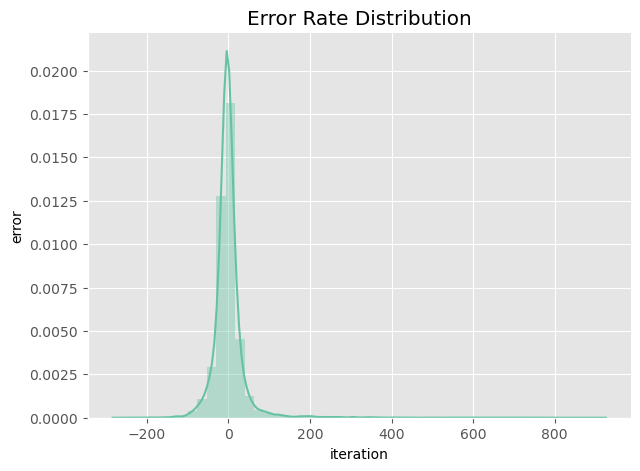

In [67]:
y_hat_tuned = catb.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

In [68]:
size = 2000

sample_exists = False

if sample_exists:
    sample_set = pd.read_csv('data/shap/sample2000.csv')
else:
    sample_set = X_test.sample(size)
sample_set

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,...,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,State_Factor,building_class,facility_type,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
2975,6.0,45574.0,1913.0,5.000000,45.7,37.0,52.693548,62.0,42.0,56.948276,75.0,47.0,57.725806,76.0,47.0,60.283333,86.0,51.0,61.064516,87.0,51.0,63.350000,87.0,53.0,62.919355,81.0,53.0,63.790323,76.0,52.0,64.800000,94.0,51.0,63.354839,84.0,...,52.285714,52.285714,3.100000,126.142857,62.196194,85.755239,77.074389,36.0,94.0,14.735737,0.427031,36.0,75.0,52.811457,12.999194,0.208552,47.0,87.0,63.674851,15.671809,0.589285,51.0,87.0,65.673297,87.0,87.0,44.0,94.0,65.159797,16.415048,0.606984,11.833333,167.083333,2082731.8,0.109409
2243,4.0,17195.0,1929.0,94.000000,120.4,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,55.0,68.661290,95.0,...,139.142857,146.285714,7.800000,102.285714,62.196194,85.755239,77.074389,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,2070278.0,0.780731
69777,4.0,334423.0,1950.0,48.857143,3.4,4.0,28.596774,58.0,9.0,31.625000,56.0,13.0,37.661290,66.0,31.0,52.333333,77.0,49.0,64.000000,86.0,55.0,72.450000,89.0,63.0,76.145161,91.0,61.0,74.516129,90.0,52.0,69.733333,92.0,42.0,59.629032,77.0,...,1.000000,1.000000,1.000000,56.000000,87.481012,80.240957,83.878522,4.0,92.0,23.643808,-0.414138,4.0,65.0,35.193100,21.536260,-0.041072,13.0,86.0,52.888292,23.158714,-0.305293,55.0,91.0,74.679032,91.0,91.0,22.0,92.0,58.740263,20.984169,-0.204013,94.000000,406.250000,1137038.2,14.369748
18861,4.0,394230.0,1965.0,85.000000,210.3,-16.0,15.677419,45.0,-8.0,17.285714,49.0,-2.0,31.661290,68.0,26.0,48.550000,80.0,37.0,60.370968,89.0,49.0,70.933333,91.0,54.0,70.354839,90.0,52.0,73.693548,88.0,41.0,63.933333,88.0,32.0,52.000000,77.0,...,142.000000,146.285714,8.028571,164.714286,95.199291,85.755239,77.074389,-16.0,91.0,28.919807,-0.400799,-16.0,50.0,20.994112,24.654540,-0.199266,-2.0,89.0,48.731362,28.778210,-0.298713,49.0,91.0,70.997969,91.0,91.0,7.0,88.0,50.724074,25.084672,-0.228427,66.583333,585.583333,82906569.0,0.404184
39762,3.0,56265.0,1924.0,62.857143,11.9,11.0,35.080645,61.0,17.0,33.910714,55.0,27.0,40.145161,59.0,33.0,52.983333,82.0,42.0,62.790323,90.0,53.0,72.650000,92.0,64.0,79.838710,98.0,59.0,74.596774,90.0,47.0,67.866667,96.0,40.0,60.193548,86.0,...,1.000000,1.000000,1.000000,99.571429,87.481012,80.240957,83.878522,11.0,98.0,23.549611,-0.056041,11.0,71.0,37.948861,20.807217,0.314929,27.0,90.0,54.324313,21.471823,0.527483,53.0,98.0,75.898387,98.0,98.0,23.0,96.0,59.478913,23.149084,0.108344,106.000000,389.166667,669553.5,5.282113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [69]:
rf = catb

In [ ]:
is_saved = False

if is_saved:
    with open('data/shap/shap_values_sample2000.pkl', 'rb') as f:
        shap_values = joblib.load(f)
else:
    shap_values = shap.TreeExplainer(rf).shap_values(sample_set)

In [ ]:
shap.initjs()

In [ ]:
shap.summary_plot(shap_values, sample_set, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, sample_set)

In [ ]:
shap.dependence_plot('energy_star_rating', shap_values, sample_set)

In [ ]:
shap.dependence_plot('State_Factor', shap_values, sample_set)